1) Exploracion de datos
1.1) Se puede decir que este dataset está “sucio” ya que pueden haber datos erróneos o faltantes. Imprima en pantalla un fragmento aleatorio del dataset e indique qué columnas sería útil modificar y de qué manera. Es útil explorar un resumen con los estadísticos básicos y les recordamos que pueden existir valores faltantes (expresados como NaNs).

In [292]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from markdown import Markdown

RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

file_name = os.path.join(cwd, '..', 'data', 'raw', 'casas_dev.csv')
# Load the dataset
df = pd.read_csv(file_name)

import sys
sys.path.append(os.path.join(cwd, '..', 'src'))
# from utils import convert_sqft_to_m2, normalize_df, plot_pairplot
from data_splitting import train_val_split, cross_val
from metrics import MSE,MAE,RMSE,R2
from models import LinearRegression
from preprocessing import handle_missing_values, normalize, one_hot_encoder, min_max_normalize
from utils import pretty_print_df, print_metrics, inverse_normalize, train_model_and_evaluate, feature_engineering

# Configurar el fondo beige para todos los plots de matplotlib
plt.rcParams['figure.facecolor'] = '#F5F5DC'  # Beige
plt.rcParams['axes.facecolor'] = '#F5F5DC'    # Beige


# Mostrar un fragmento aleatorio de 10 filas
print("\nMuestra aleatoria de 10 filas:")
display(df.sample(10))

# Mostrar estadísticas básicas
print("\nEstadísticas básicas:")
display(df.describe())

# Mostrar información sobre valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Comentarios sobre las columnas a modificar:
print("\nColumnas que sería útil modificar:")
print("- rooms: Hay valores faltantes que deberían imputarse")
print("- age: Hay valores faltantes que deberían imputarse") 
print("- area_units: Hay dos unidades diferentes (m2 y sqft) que deberían unificarse")
print("- area: Debería convertirse todo a la misma unidad")



Current working directory: c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\tp1\notebooks

Muestra aleatoria de 10 filas:


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0
731,710.0,sqft,0,0,7.0,493.0,40.706159,-74.021740,2.0
299,128.0,m2,0,0,9.0,247.0,-34.608909,-58.392922,NaN
110,1399.0,sqft,0,0,11.0,948.0,40.722493,-73.977268,4.0
72,103.0,m2,1,0,15.0,190.0,-34.573679,-58.460096,3.0
86,47.0,m2,1,0,12.0,93.0,-34.640750,-58.430882,1.0



Estadísticas básicas:


,area,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
mean,533.598889,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,502.318230,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,93.000000,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,164.500000,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,980.000000,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000
max,2164.000000,1.000000,1.000000,20.000000,1992.000000,40.764550,-58.295919,5.000000



Valores faltantes por columna:
area            0
area_units      0
is_house        0
has_pool        0
age           130
price           0
lat             0
lon             0
rooms          72
dtype: int64

Columnas que sería útil modificar:
- rooms: Hay valores faltantes que deberían imputarse
- age: Hay valores faltantes que deberían imputarse
- area_units: Hay dos unidades diferentes (m2 y sqft) que deberían unificarse
- area: Debería convertirse todo a la misma unidad


In [294]:
# Convertir todas las áreas a metros cuadrados (m2)
# 1 sqft = 0.092903 m2
df = pd.read_csv('../data/raw/casas_dev.csv')

for index, row in df.iterrows():
    if row['area_units'] == 'sqft':
        df.at[index, 'area'] = row['area'] * 0.092903
    else:
        df.at[index, 'area'] = row['area']

df = handle_missing_values(df)

# Verificar que no queden valores nulos
print("\nValores faltantes después de la limpieza:")
pretty_print_df(df.isnull().sum().to_frame(name='Valores Nulos'))

# Guardar el dataset procesado
df.to_csv('../data/processed/casas_dev_processed.csv', index=False)
print("\nDataset procesado guardado en data/processed/casas_dev_processed.csv")

# Mostrar las primeras filas del dataset procesado
print("\nPrimeras filas del dataset procesado:")
pretty_print_df(df.head())



Valores faltantes después de la limpieza:


|   Valores Nulos |
|----------------:|
|               0 |
|               0 |
|               0 |
|               0 |
|               0 |
|               0 |
|               0 |
|               0 |
|               0 |


Dataset procesado guardado en data/processed/casas_dev_processed.csv

Primeras filas del dataset procesado:


|     area | area_units   |   is_house |   has_pool |   age |   price |      lat |      lon |   rooms |
|---------:|:-------------|-----------:|-----------:|------:|--------:|---------:|---------:|--------:|
|  58.9934 | sqft         |          1 |          0 |    18 |     546 |  40.6791 | -74.0078 |       2 |
| 102.007  | sqft         |          0 |          0 |     9 |     759 |  40.7128 | -73.9678 |       3 |
|  61.9663 | sqft         |          0 |          0 |     7 |     464 |  40.6699 | -74.0294 |       2 |
| 127      | m2           |          1 |          1 |    16 |     251 | -34.6004 | -58.4153 |       4 |
| 128.02   | sqft         |          0 |          0 |     8 |     963 |  40.7223 | -73.9832 |       4 |

##### En este caso elegí rellenar los valores NaN con el promedio de cada columna, porque era la forma más simple de corregirlo, aunque también se podría haber pensado de otra forma pero me parece que no hace falta complicarse mucho.

1.2) Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar la relación entre las variables. Para esto, es útil el comando pairplot. ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? Se permite la creación de gráficos adicionales que considere relevantes.

<Figure size 1200x800 with 0 Axes>

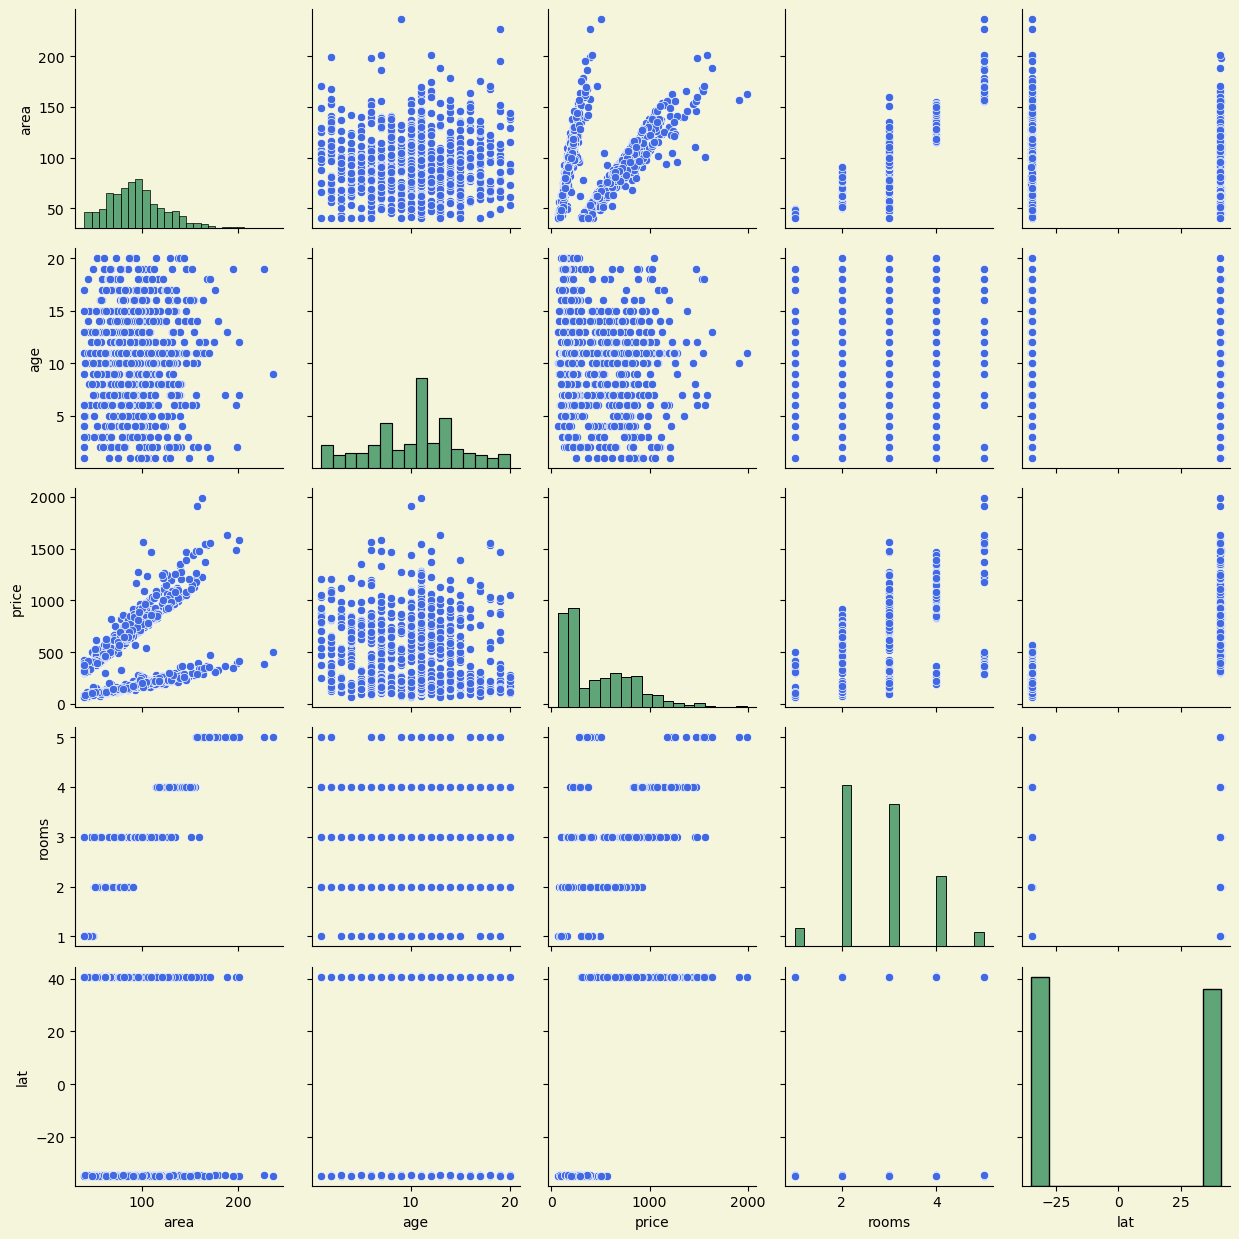

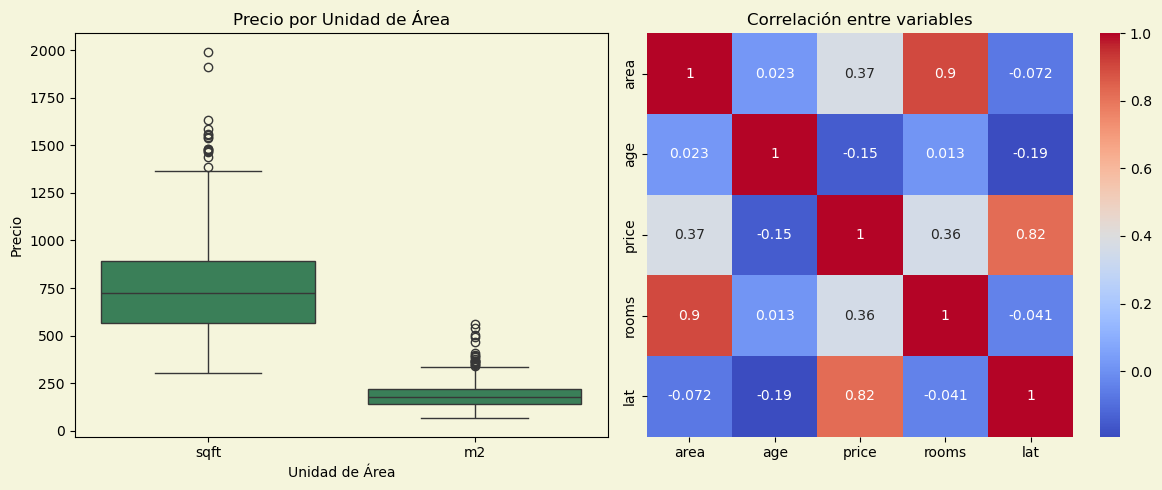

In [295]:
# Crear pairplot para visualizar relaciones entre variables
import seaborn as sns
import matplotlib.pyplot as plt

# Crear pairplot con todas las variables numéricas
plt.figure(figsize=(12, 8))
sns.pairplot(df[['area', 'age', 'price', 'rooms','lat']], diag_kind='hist', plot_kws={'color': 'royalblue'}, diag_kws={'color': 'seagreen'})
plt.tight_layout()
plt.show()

# Crear boxplots adicionales para variables categóricas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df, x='area_units', y='price', ax=axes[0],color='seagreen')
axes[0].set_title('Precio por Unidad de Área')
axes[0].set_xlabel('Unidad de Área')
axes[0].set_ylabel('Precio')

# agregar un grafico de correlacion entre las variables
sns.heatmap(df[['area', 'age', 'price', 'rooms','lat']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables')
plt.tight_layout()
plt.show()



##### Gracias a los gráficos se puede ver a simple vista que hay una gran correlación entre área y habitaciones, lo cual tiene bastante sentido, pero además encontramos que hay una gran correlación entre precios y la región de la casa (variable lat o también si las unidades están en sqft o m2), esto indica que la ubicación va a ser un factor muy determinante en el precio.

1.3) Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train) y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar los datos para lograr un mejora el condicionamiento numérico de los algortmos de aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá invertir la normalización para volver a las escalas originales.

In [296]:
df = pd.read_csv('../data/raw/casas_dev.csv')

for index, row in df.iterrows():
    if row['area_units'] == 'sqft':
        df.at[index, 'area'] = row['area'] * 0.092903
    else:
        df.at[index, 'area'] = row['area']

df = handle_missing_values(df)

# Dividir en conjuntos de entrenamiento y validación (80-20)
train_df, val_df = train_val_split(df, test_size=0.2, random_state=RANDOM_STATE)
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()


print("Tamaño del conjunto de entrenamiento:", len(train_df))
print("Tamaño del conjunto de validación:", len(val_df))

# Normalizar conjunto de entrenamiento y obtener parámetros
train_df_normalized, val_df_normalized, normalization_params = min_max_normalize(train_df.copy(), val_df.copy(), numeric_columns)

print("\nRango de valores después de la normalización (conjunto de entrenamiento):")
pretty_print_df(train_df_normalized[numeric_columns].describe().loc[['min', 'max']])

# guardar los conjuntos de entrenamiento y validación normalizados
train_df_normalized.to_csv('../data/processed/train_df_normalized.csv', index=False)
val_df_normalized.to_csv('../data/processed/val_df_normalized.csv', index=False)


Tamaño del conjunto de entrenamiento: 720
Tamaño del conjunto de validación: 180

Rango de valores después de la normalización (conjunto de entrenamiento):


|   area |   is_house |   has_pool |   age |   price |   lat |   lon |   rooms |
|-------:|-----------:|-----------:|------:|--------:|------:|------:|--------:|
|      0 |          0 |          0 |     0 |      65 |     0 |     0 |       0 |
|      1 |          1 |          1 |     1 |    1992 |     1 |     1 |       1 |

Importante señalar que decidí no normalizar el precio, porque de esa forma podemos tener directamente el precio desnormalizado para ver las métricas de error.

Implementacion de Regresion Lineal

2.1) Implemente una clase de regresión lineal. El constructor deberá recibir X e y, y se deberá incluir como métodos de entrenamiento de la clase: entrenamiento mediante la pseudo-inversa y entrenamiento mediante descenso por gradiente. En ambos casos se debe almacenar como atributo self.coef los coeficientes (pesos) resultantes de la regresión. NOTA: Asegúrese de que haya un método que permita imprimir los coeficientes con los nombres de sus respectivas variables de forma prolija.

2.2) Implemente la función de pérdida utilizando el Error Cuadrático Medio (ECM).

2.3) Verifique que su implementación de la regresión lineal funcione correctamente tanto
para cuando se tiene una característica como para múltiples características.

In [297]:
train_model_and_evaluate(train_df_normalized,val_df_normalized,features=['area'],method='gradient')

Gradient Descent


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |       5.43389 |
| area      |       1.55392 |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |          Valor |
|:----------|---------------:|
| MSE       | 117483         |
| MAE       |    292.218     |
| RMSE      |    342.758     |
| R2        |      0.0150003 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |          Valor |
|:----------|---------------:|
| MSE       | 112599         |
| MAE       |    283.935     |
| RMSE      |    335.557     |
| R2        |      0.0968179 |

In [298]:
train_model_and_evaluate(train_df_normalized,val_df_normalized,features=['area'],method='pseudo')

Pseudo Inverse


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |       5.42349 |
| area      |       1.5909  |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |          Valor |
|:----------|---------------:|
| MSE       | 117343         |
| MAE       |    292.492     |
| RMSE      |    342.554     |
| R2        |      0.0161753 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |         Valor |
|:----------|--------------:|
| MSE       | 112171        |
| MAE       |    283.901    |
| RMSE      |    334.919    |
| R2        |      0.100249 |

In [299]:
features = [col for col in numeric_columns if col != 'price']
train_model_and_evaluate(train_df_normalized, val_df_normalized, features=features, method='gradient')

Gradient Descent


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |     3.12162   |
| area      |     0.798335  |
| is_house  |     0.0571107 |
| has_pool  |     0.18658   |
| age       |     0.78303   |
| lat       |     2.35504   |
| lon       |     0.769551  |
| rooms     |     1.18464   |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |        Valor |
|:----------|-------------:|
| MSE       | 29281.7      |
| MAE       |   105.043    |
| RMSE      |   171.119    |
| R2        |     0.754497 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |        Valor |
|:----------|-------------:|
| MSE       | 32485.3      |
| MAE       |   108.769    |
| RMSE      |   180.237    |
| R2        |     0.739427 |

In [300]:
train_model_and_evaluate(train_df_normalized,val_df_normalized,features=features,method='pseudo')

Pseudo Inverse


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |      5.06688  |
| area      |      1.92145  |
| is_house  |      0.112135 |
| has_pool  |      0.10816  |
| age       |     -0.158546 |
| lat       |      0.996732 |
| lon       |     -0.496688 |
| rooms     |      0.097295 |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 6307.47     |
| MAE       |   40.0406   |
| RMSE      |   79.4196   |
| R2        |    0.947117 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |      Valor |
|:----------|-----------:|
| MSE       | 6768.31    |
| MAE       |   39.3362  |
| RMSE      |   82.2697  |
| R2        |    0.94571 |

Conclusiones Implementación de Regresión Lineal

Se desarrollaron dos métodos para entrenar el modelo de regresión lineal: pseudo-inversa y descenso por gradiente. Ambos enfoques demostraron resultados satisfactorios, aunque el método por pseudo-inversa resulto adaptarse mejor a nuestro problema y dio mejores resultados.

Aplicación de Modelos de Regresión
3.1) Realice una regresión lineal simple (con una sola característica) para predecir el precio
de una propiedad utilizando como variable explicativa solo el area.

Pseudo Inverse


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |       5.42349 |
| area      |       1.5909  |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |          Valor |
|:----------|---------------:|
| MSE       | 117343         |
| MAE       |    292.492     |
| RMSE      |    342.554     |
| R2        |      0.0161753 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |         Valor |
|:----------|--------------:|
| MSE       | 112171        |
| MAE       |    283.901    |
| RMSE      |    334.919    |
| R2        |      0.100249 |

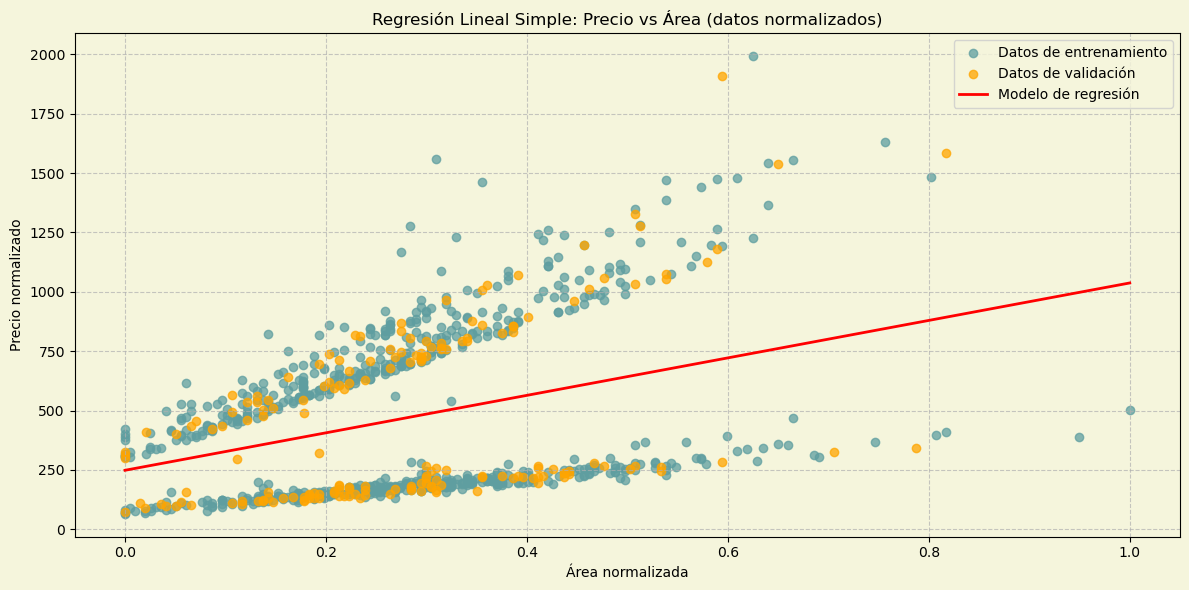

In [301]:
train_model_and_evaluate(train_df_normalized,val_df_normalized,features=['area'],method='pseudo')

# Visualizar el modelo de regresión lineal simple
plt.figure(figsize=(12, 6))

# Datos originales
plt.scatter(train_df_normalized['area'], train_df_normalized['price'], 
            alpha=0.75, color='cadetblue', label='Datos de entrenamiento')
plt.scatter(val_df_normalized['area'], val_df_normalized['price'], 
            alpha=0.75, color='orange', label='Datos de validación')

# Obtener el modelo entrenado con el método de la pseudo-inversa
modelo = LinearRegression(train_df_normalized[['area']], train_df_normalized['price'])
modelo.fit_pseudo_inverse()

# Crear puntos para la línea de regresión
x_range = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = modelo.predict(pd.DataFrame(x_range, columns=['area']))

# Graficar la línea de regresión
plt.plot(x_range, y_pred, color='red', linewidth=2, label='Modelo de regresión')

# Añadir detalles al gráfico
plt.title('Regresión Lineal Simple: Precio vs Área (datos normalizados)')
plt.xlabel('Área normalizada')
plt.ylabel('Precio normalizado')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


3.2) Desarrolle un modelo de regresión lineal que prediga el precio en función de las caraceterísticas que considere relevantes. Utilizando el modelo entrenado, prediga el precio de vivienda_Amanda.csv.

In [302]:
# Cargar y preparar datos de Amanda
file_name = os.path.join(cwd, '..', 'data', 'raw', 'vivienda_Amanda.csv')
amanda_df = pd.read_csv(file_name)

for index, row in amanda_df.iterrows():
    if row['area_units'] == 'sqft':
        amanda_df.at[index, 'area'] = row['area'] * 0.092903

# Seleccionar características relevantes
features = amanda_df.columns.tolist()
features = [col for col in features if col != 'price' and col != 'area_units']

# Preparar datos de entrenamiento y validación
X_train = train_df_normalized[features]
y_train = train_df_normalized['price']
X_val = val_df_normalized[features]
y_val = val_df_normalized['price']
# Entrenar modelo usando todas las características con pseudo-inversa
modelo_completo_pseudo = LinearRegression(X_train, y_train)
modelo_completo_pseudo.fit_pseudo_inverse()

# Realizar predicciones con pseudo-inversa
y_train_pred_pseudo = modelo_completo_pseudo.predict(X_train)
y_val_pred_pseudo = modelo_completo_pseudo.predict(X_val)

# Imprimir coeficientes y métricas para pseudo-inversa
print("Pseudo-Inversa:")
modelo_completo_pseudo.print_coefficients()

print_metrics(y_train, y_train_pred_pseudo, "Modelo Completo Pseudo-inversa (Entrenamiento)")
print_metrics(y_val, y_val_pred_pseudo, "Modelo Completo Pseudo-inversa (Validación)")

# Entrenar modelo usando todas las características con gradiente descendiente
modelo_completo_gd = LinearRegression(X_train, y_train)
modelo_completo_gd.fit_gradient_descent()

# Realizar predicciones con gradiente descendiente
y_train_pred_gd = modelo_completo_gd.predict(X_train)
y_val_pred_gd = modelo_completo_gd.predict(X_val)

# Imprimir coeficientes y métricas para gradiente descendiente
print("Gradiente Descendiente:")
modelo_completo_gd.print_coefficients()
print_metrics(y_train, y_train_pred_gd, "Modelo Completo GD (Entrenamiento)")
print_metrics(y_val, y_val_pred_gd, "Modelo Completo GD (Validación)")

# Normalizar datos de Amanda
amanda_normalized = pd.DataFrame()
for col in features:
    min_val, max_val = normalization_params[col]
    amanda_normalized[col] = (amanda_df[col] - min_val) / (max_val - min_val)

# Predecir precio para la vivienda de Amanda con ambos modelos
X_amanda = amanda_normalized[features].values
precio_amanda_norm_pseudo = modelo_completo_pseudo.predict(X_amanda)
precio_amanda_norm_gd = modelo_completo_gd.predict(X_amanda)

print("\nPrecio predicho para la vivienda de Amanda (Pseudo-inversa):")
print(f"${precio_amanda_norm_pseudo[0]:,.2f}")

print("\nPrecio predicho para la vivienda de Amanda (Gradiente Descendiente):")
print(f"${precio_amanda_norm_gd[0]:,.2f}")

Pseudo-Inversa:


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |    -2818.97   |
| area      |      932.633  |
| is_house  |       80.8486 |
| has_pool  |       45.892  |
| age       |      -56.7988 |
| lat       |     3313.79   |
| lon       |     2698.45   |
| rooms     |       37.2775 |

### Métricas del modelo Modelo Completo Pseudo-inversa (Entrenamiento)

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 15015.2     |
| MAE       |    88.3444  |
| RMSE      |   122.536   |
| R2        |     0.87411 |

### Métricas del modelo Modelo Completo Pseudo-inversa (Validación)

| Métrica   |        Valor |
|:----------|-------------:|
| MSE       | 16457        |
| MAE       |    88.5736   |
| RMSE      |   128.285    |
| R2        |     0.867994 |

Gradiente Descendiente:


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |      190.085  |
| area      |      187.268  |
| is_house  |       23.8462 |
| has_pool  |       28.4867 |
| age       |       30.7405 |
| lat       |      391.982  |
| lon       |     -200.006  |
| rooms     |      251.724  |

### Métricas del modelo Modelo Completo GD (Entrenamiento)

| Métrica   |        Valor |
|:----------|-------------:|
| MSE       | 21073.3      |
| MAE       |    92.6479   |
| RMSE      |   145.167    |
| R2        |     0.823318 |

### Métricas del modelo Modelo Completo GD (Validación)

| Métrica   |        Valor |
|:----------|-------------:|
| MSE       | 22183.1      |
| MAE       |    89.4969   |
| RMSE      |   148.94     |
| R2        |     0.822064 |


Precio predicho para la vivienda de Amanda (Pseudo-inversa):
$790.19

Precio predicho para la vivienda de Amanda (Gradiente Descendiente):
$783.87


3.3) En el dataset, ¿cuál es el valor promedio por metro cuadrado de una casa?

In [303]:
df = pd.read_csv('../data/raw/casas_dev.csv')

# Convertir sqft a m2
for index, row in df.iterrows():
    if row['area_units'] == 'sqft':
        df.at[index, 'area'] = row['area'] * 0.092903
    else:
        df.at[index, 'area'] = row['area']



# valor promedio por metro cuadrado de las casas en el dataset de entrenamiento con todas las casas convertidas a m2
valor_por_m2_casas = df[df['is_house'] == 1 ]['price'] / df[df['is_house'] == 1]['area']
valor_promedio_m2_casas = valor_por_m2_casas.mean()
print(f"El valor promedio por metro cuadrado de las casas es: ${valor_promedio_m2_casas:,.2f}")

El valor promedio por metro cuadrado de las casas es: $3.58


3.4) Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la construcción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado.

In [304]:
# Analizamos cómo afecta la pileta al precio de la propiedad
# Creamos un modelo de regresión lineal para evaluar el impacto de tener pileta

# Preparamos los datos para el modelo
X_train = train_df_normalized.drop(columns=['price','area_units'])
y_train = train_df_normalized['price']

# Entrenamos un modelo de regresión lineal usando pseudo-inversa
modelo = LinearRegression(X_train, y_train)
modelo.fit_pseudo_inverse()

# Mostramos los coeficientes para ver el impacto de la pileta en el precio
modelo.print_coefficients()

# Calculamos el impacto específico de la pileta
coeficientes = pd.DataFrame(modelo.coef.flatten(), index=['intercept'] + list(modelo.features), columns=['Coeficiente'])
impacto_pileta = coeficientes.loc['has_pool', 'Coeficiente'] if 'has_pool' in coeficientes.index else 0

print(f"\nImpacto en coeficiente de construir una pileta en el precio de la propiedad: ${impacto_pileta:,.2f}")


### Coeficientes del modelo

| Feature   |   Coeficiente |
|:----------|--------------:|
| intercept |    -2818.97   |
| area      |      932.633  |
| is_house  |       80.8486 |
| has_pool  |       45.892  |
| age       |      -56.7988 |
| lat       |     3313.79   |
| lon       |     2698.45   |
| rooms     |       37.2775 |


Impacto en coeficiente de construir una pileta en el precio de la propiedad: $45.89


Conclusión: La construcción de una pileta tendría un impacto positivo en el precio de la propiedad como se muestra arriba, sin embargo, la cantidad que puede llegar a aumentar depende altamente de otras features, como pueden ser la zona (lat y lon) y el area, como se puede apreciar en los coeficientes.

4. Feature Engineering
El feature engineering es una técnica que se utiliza para aportar mayor flexibilidad a los
modelos.
4.1) Construya un conjunto de características derivadas a partir de las originales, que le pa-
rezca relevante para predecir el precio de una propiedad, utilizando técnicas de Feature
Engineering.

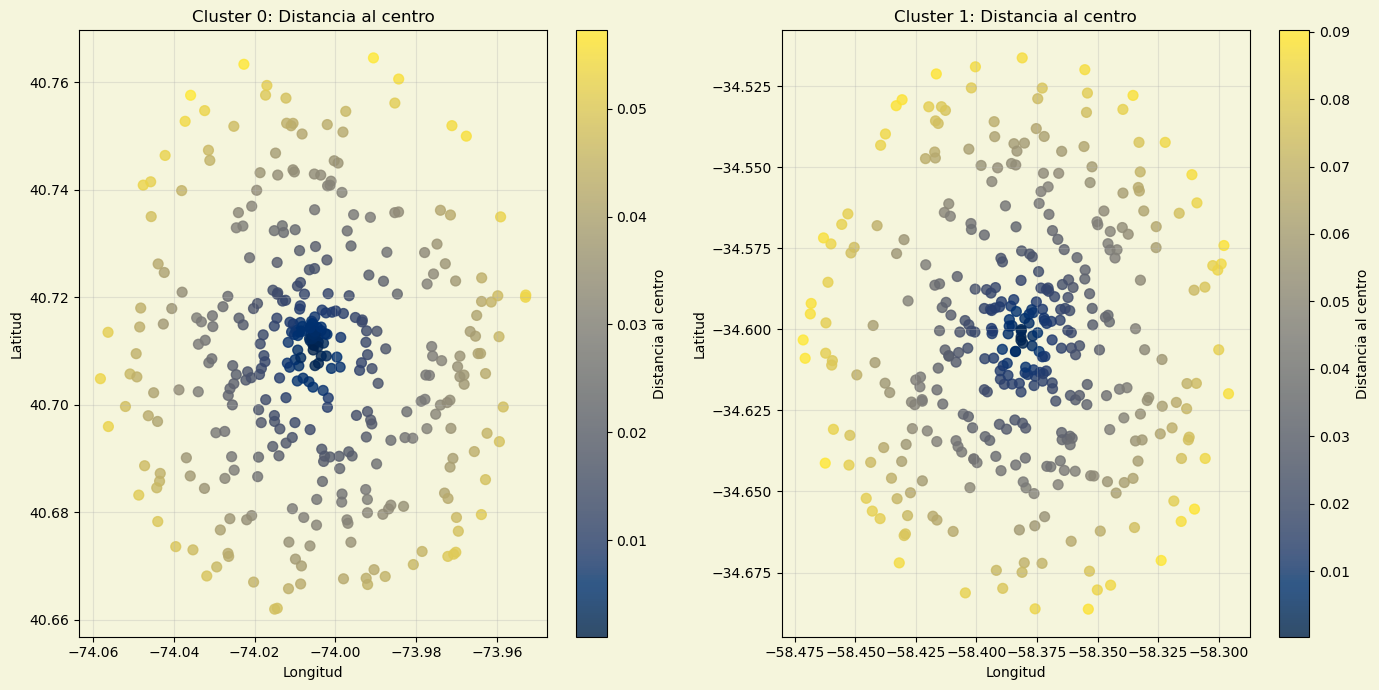

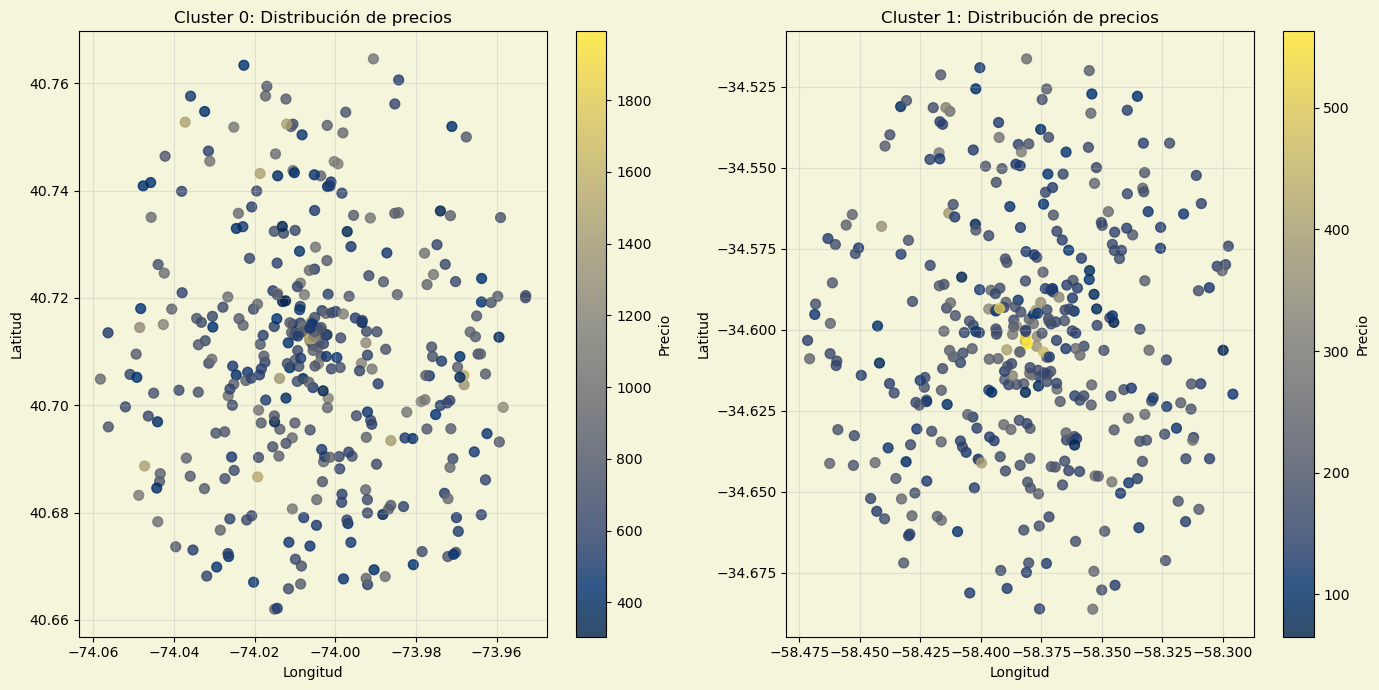

Vemos que no es tan obvio, pero se aprecia que aveces las casas más cercanas al centro del cluster tienden a ser más caras, entonces la feature de distancia al centro puede ayudar bastante con la predicción.


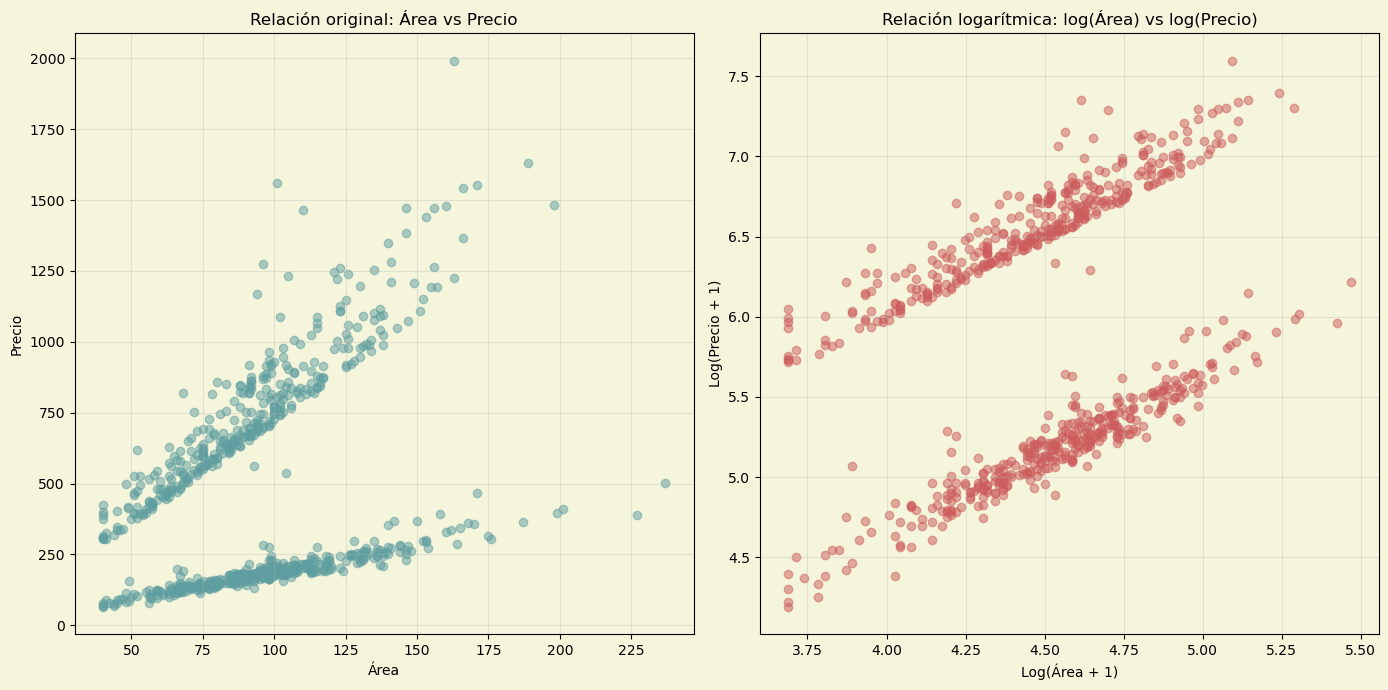


Ventajas de la transformación logarítmica:
1. Normaliza distribuciones sesgadas, acercándolas a una distribución normal
2. Reduce el impacto de valores atípicos extremos
3. Linealiza relaciones exponenciales entre variables
4. Estabiliza la varianza en los datos
5. Mejora el rendimiento de modelos que asumen linealidad o normalidad



In [305]:
# Creamos nuevas características derivadas

df = pd.read_csv('../data/raw/casas_dev.csv')

for index, row in df.iterrows():
    if row['area_units'] == 'sqft':
        df.at[index, 'area'] = row['area'] * 0.092903
    else:
        df.at[index, 'area'] = row['area']

df = handle_missing_values(df)

# Dividir en conjuntos de entrenamiento y validación (80-20)
train_df, val_df = train_val_split(df, test_size=0.2, random_state=RANDOM_STATE)
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

train_df_fe = feature_engineering(train_df)
val_df_fe = feature_engineering(val_df)
plt.figure(figsize=(14, 7))

# Gráfico para Cluster 0
plt.subplot(1, 2, 1)
cluster0 = train_df_fe[train_df_fe['cluster'] == 0]
scatter0 = plt.scatter(cluster0['lon'], cluster0['lat'], 
                      c=cluster0['distance_from_center'], 
                      cmap='cividis', 
                      alpha=0.8, 
                      s=50)
plt.colorbar(scatter0, label='Distancia al centro')
plt.title('Cluster 0: Distancia al centro')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, alpha=0.3)

# Gráfico para Cluster 1
plt.subplot(1, 2, 2)
cluster1 = train_df_fe[train_df_fe['cluster'] == 1]
scatter1 = plt.scatter(cluster1['lon'], cluster1['lat'], 
                      c=cluster1['distance_from_center'], 
                      cmap='cividis', 
                      alpha=0.8, 
                      s=50)
plt.colorbar(scatter1, label='Distancia al centro')
plt.title('Cluster 1: Distancia al centro')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Crear visualización de clusters con mapa de calor de precios
plt.figure(figsize=(14, 7))

# Gráfico para Cluster 0
plt.subplot(1, 2, 1)
cluster0 = train_df_fe[train_df_fe['cluster'] == 0]
scatter0 = plt.scatter(cluster0['lon'], cluster0['lat'], 
                      c=cluster0['price'], 
                      cmap='cividis', 
                      alpha=0.8, 
                      s=50)
plt.colorbar(scatter0, label='Precio')
plt.title('Cluster 0: Distribución de precios')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, alpha=0.3)

# Gráfico para Cluster 1
plt.subplot(1, 2, 2)
cluster1 = train_df_fe[train_df_fe['cluster'] == 1]
scatter1 = plt.scatter(cluster1['lon'], cluster1['lat'], 
                      c=cluster1['price'], 
                      cmap='cividis', 
                      alpha=0.8, 
                      s=50)
plt.colorbar(scatter1, label='Precio')
plt.title('Cluster 1: Distribución de precios')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Vemos que no es tan obvio, pero se aprecia que aveces las casas más cercanas al centro del cluster tienden a ser más caras, entonces la feature de distancia al centro puede ayudar bastante con la predicción.")

# Comparación de la relación entre área y precio (original vs logarítmica)
plt.figure(figsize=(14, 7))

# Relación original
plt.subplot(1, 2, 1)
plt.scatter(train_df_fe['area'], train_df_fe['price'], alpha=0.5, color='cadetblue')
plt.title('Relación original: Área vs Precio')
plt.xlabel('Área')
plt.ylabel('Precio')
plt.grid(True, alpha=0.3)

# Relación logarítmica
plt.subplot(1, 2, 2)
plt.scatter(train_df_fe['log_area'], np.log1p(train_df_fe['price']), alpha=0.5, color='indianred')
plt.title('Relación logarítmica: log(Área) vs log(Precio)')
plt.xlabel('Log(Área + 1)')
plt.ylabel('Log(Precio + 1)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Texto explicativo sobre las ventajas de la transformación logarítmica
print("""
Ventajas de la transformación logarítmica:
1. Normaliza distribuciones sesgadas, acercándolas a una distribución normal
2. Reduce el impacto de valores atípicos extremos
3. Linealiza relaciones exponenciales entre variables
4. Estabiliza la varianza en los datos
5. Mejora el rendimiento de modelos que asumen linealidad o normalidad
""")



# Eliminar las columnas de centro de cluster ya que no son necesarias
train_df_fe.drop(columns=['center_lat', 'center_lon'], inplace=True)
val_df_fe.drop(columns=['center_lat', 'center_lon'], inplace=True)

numeric_columns = train_df_fe.select_dtypes(include=[np.number]).columns.tolist()

# Guardar los datasets no normalizados
train_df_fe.to_csv('../data/processed/train_df_fe.csv', index=False)
val_df_fe.to_csv('../data/processed/val_df_fe.csv', index=False)

train_df_normalized, val_df_normalized, normalization_params = min_max_normalize(train_df_fe.copy(), val_df_fe.copy(), numeric_columns)
train_df_normalized.to_csv('../data/processed/train_df_fe_normalized.csv', index=False)
val_df_normalized.to_csv('../data/processed/val_df__fe_normalized.csv', index=False)

4.2) Realice una regresión lineal como en 3.2), incorporando las características que desarrolló
en el punto 4.1).

In [306]:
# Cargar los datos normalizados
train_df_norm = pd.read_csv('../data/processed/train_df_fe_normalized.csv')
val_df_norm = pd.read_csv('../data/processed/val_df__fe_normalized.csv')

# Seleccionar todas las columnas excepto 'price' como características
features = [col for col in train_df_norm.columns if col != 'price']

train_model_and_evaluate(train_df_norm,val_df_norm,features=features,method='pseudo')



Pseudo Inverse


### Coeficientes del modelo

| Feature              |   Coeficiente |
|:---------------------|--------------:|
| intercept            |    4.76786    |
| area                 |    0.139962   |
| is_house             |    0.166824   |
| has_pool             |    0.122949   |
| age                  |   -0.11863    |
| lat                  |    1.2918     |
| lon                  |   -0.175135   |
| rooms                |   -0.00866168 |
| cluster              |    0.00764294 |
| distance_from_center |   -0.291729   |
| area_per_room        |   -0.178854   |
| log_area             |    1.84458    |
| log_rooms            |   -0.163418   |
| log_age              |   -0.0615058  |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 3433.57     |
| MAE       |   30.4884   |
| RMSE      |   58.5967   |
| R2        |    0.971212 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 3910.36     |
| MAE       |   29.4014   |
| RMSE      |   62.5329   |
| R2        |    0.968634 |

Como vemos en las metricas, al agregar las columnas que nos parecen relevantes mejoró bastante el modelo, llegando a tener errores mas bajos en todas las metricas.

4.3) Repita el proceso del ítem anterior generando 300 nuevos features como potencias de
los features anteriores (por ejemplo: [x1^2,x2^5,...,xn^12]).

Cantidad de filas en el dataframe de entrenamiento: 720
Número de features originales: 13
Número de features expandidos: 313
Métricas del modelo con features expandidos:


### Métricas del modelo Features Expandidos (Train)

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 9654.16     |
| MAE       |   72.0732   |
| RMSE      |   98.2556   |
| R2        |    0.919058 |

### Métricas del modelo Features Expandidos (Val)

| Métrica   |        Valor |
|:----------|-------------:|
| MSE       | 947979       |
| MAE       |    719.05    |
| RMSE      |    973.642   |
| R2        |     -6.60398 |

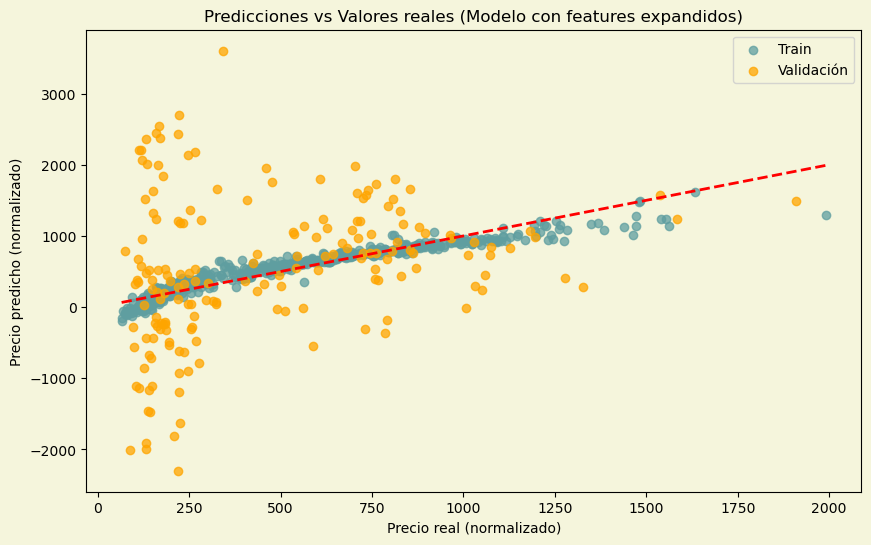

In [307]:
# Cargar los datos normalizados
train_df = pd.read_csv('../data/processed/train_df_fe.csv')
val_df = pd.read_csv('../data/processed/val_df_fe.csv')

# Extraer el precio de los dataframes
y_train = train_df['price']
y_val = val_df['price']

# Eliminar la columna de precio de los dataframes
train_df = train_df.drop(columns=['price'])
val_df = val_df.drop(columns=['price'])


# Seleccionar todas las columnas excepto 'price' como características
features = [col for col in train_df.columns if col != 'price']

# Generar 300 nuevos features aleatorios
nuevas_columnas_train = {}
nuevas_columnas_val = {}

existing_features = set()

for i in range(300):
    while True:
        # Elegir una feature aleatoria
        feature = np.random.choice(features)
        
        # Elegir una potencia aleatoria entre 2 y 80
        potencia = np.random.randint(2, 80)
        
        # Crear nombre para la nueva columna
        nuevo_nombre = f"{feature}_pow_{potencia}"
        
        # Verificar si la nueva columna ya existe
        if nuevo_nombre not in existing_features:
            existing_features.add(nuevo_nombre)
            break
    
    # Calcular potencias
    nuevas_columnas_train[nuevo_nombre] = train_df[feature] ** potencia
    nuevas_columnas_val[nuevo_nombre] = val_df[feature] ** potencia

# Concatenar todas las nuevas columnas de una vez
train_df_expanded = pd.concat([train_df, pd.DataFrame(nuevas_columnas_train)], axis=1)
val_df_expanded = pd.concat([val_df, pd.DataFrame(nuevas_columnas_val)], axis=1)

# Normalizar los nuevos conjuntos de datos expandidos
train_df_expanded,val_df_expanded, normalization_params_expanded = min_max_normalize(train_df_expanded,val_df_expanded, train_df_expanded.columns)

# Preparar matrices de features para entrenamiento y validación
X_train_expanded = train_df_expanded
X_val_expanded = val_df_expanded

# Obtener lista de features expandidos
features_expandidos = train_df_expanded.columns.tolist()

print(f"Cantidad de filas en el dataframe de entrenamiento: {len(train_df_expanded)}")
print(f"Número de features originales: {len(features)}")
print(f"Número de features expandidos: {len(features_expandidos)}")

# Entrenar modelo con features expandidos usando tasa de aprendizaje más pequeña
modelo_expandido = LinearRegression(X_train_expanded, y_train)
modelo_expandido.fit_pseudo_inverse()

# Realizar predicciones
y_pred_train_exp = modelo_expandido.predict(X_train_expanded)
y_pred_val_exp = modelo_expandido.predict(X_val_expanded)

# Calcular métricas
mse_train_exp = np.mean((y_train - y_pred_train_exp) ** 2)
mse_val_exp = np.mean((y_val - y_pred_val_exp) ** 2)
r2_train_exp = 1 - mse_train_exp / np.var(y_train)
r2_val_exp = 1 - mse_val_exp / np.var(y_val)

print("Métricas del modelo con features expandidos:")
print_metrics(y_train, y_pred_train_exp, model_name="Features Expandidos (Train)")
print_metrics(y_val, y_pred_val_exp, model_name="Features Expandidos (Val)")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_exp,color = 'cadetblue', alpha=0.75, label='Train')
plt.scatter(y_val, y_pred_val_exp,color = 'orange', alpha=0.75, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title('Predicciones vs Valores reales (Modelo con features expandidos)')
plt.legend()
plt.show()



Como se puede apreciar en el gráfico, la predicción para el set de Train es casi perfecta, pero la de Validation es completamente errónea. Esto es un claro caso de overfitting, que sucede a causa de las 300 features que generamos sin sentido alguno, sólo reusando nuestros datos ya existentes llegando a este resultado que se ajusta a nuestros datos de train.

#### Conclusiones sobre el impacto del Feature Engineering

##### La incorporación de nuevas características mediante técnicas de feature engineering, ha mejorado significativamente el desempeño del modelo al reducir los errores en todas las métricas. Sin embargo, al generar 300 features adicionales sin un criterio específico, se observó un claro caso de sobreajuste.

5.1) Modifique la clase de Regresión Lineal para que pueda recibir como parámetros dos
coeficientes de regularización L2 y L1, que por defecto serán 0.

5.2) Entrene un modelo de regresión lineal con regularización L2 (a veces llamado “Ridge
regression”) utilizando como características las mismas que en el punto 4.2) y grafique
el valor de los parametros w∗en función del coeficiente de penalización λ.

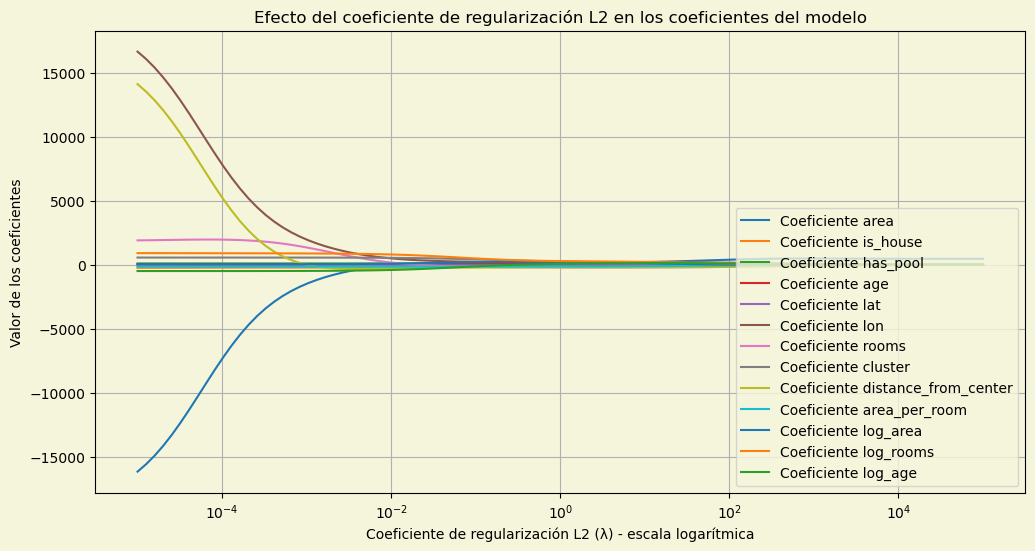

In [308]:
# Cargar los datos normalizados
train_df_norm = pd.read_csv('../data/processed/train_df_fe_normalized.csv')
val_df_norm = pd.read_csv('../data/processed/val_df__fe_normalized.csv')

# Seleccionar todas las columnas excepto 'price' como características
features = [col for col in train_df_norm.columns if col != 'price']

X_train = train_df_norm[features]
y_train = train_df_norm['price']

l2_values = np.logspace(-5, 5, 100) 
coeficientes = []

for l2 in l2_values:
    modelo_ridge = LinearRegression(X_train, y_train, l2=l2)
    modelo_ridge.fit_normal_equation()
    coeficientes.append(modelo_ridge.coef.flatten())

coeficientes = np.array(coeficientes)

plt.figure(figsize=(12, 6))
for i in range(coeficientes.shape[1]-1):
    plt.semilogx(l2_values, coeficientes[:, i], label=f'Coeficiente {features[i]}')
plt.xlabel('Coeficiente de regularización L2 (λ) - escala logarítmica')
plt.ylabel('Valor de los coeficientes')
plt.title('Efecto del coeficiente de regularización L2 en los coeficientes del modelo')
plt.legend(loc='lower right')
plt.grid(True, which="both", ls="-")
plt.show()


5.3) Realice el mismo gráfico del ítem anterior pero ahora utilizando regularización L1 (a
veces llamado “LASSO regression”). Recuerde que no hay una solución analítica para
w∗con regularización L1, por lo cual solo será posible entrenar el modelo mediante
gradiente descendiente. Analice el gráfico obtenido y compárelo con el anterior. ¿Qué
conclusiones se pueden extraer en cuanto al efecto de utilizar regularización L1 vs. L2?

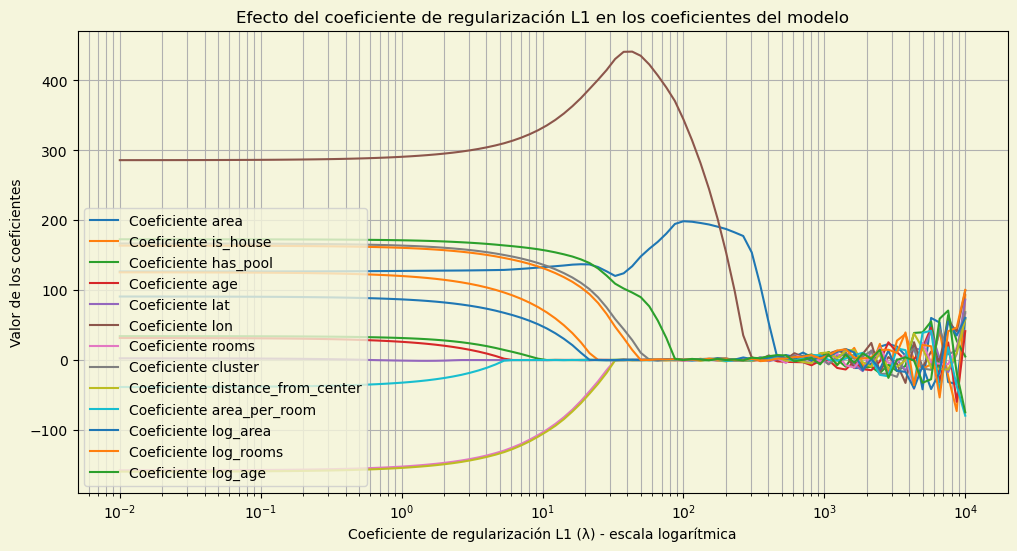

In [309]:
# Cargar los datos normalizados
train_df_norm = pd.read_csv('../data/processed/train_df_fe_normalized.csv')
val_df_norm = pd.read_csv('../data/processed/val_df__fe_normalized.csv')

features = [col for col in train_df_norm.columns if col != 'price']

X_train = train_df_norm[features]
y_train = train_df_norm['price']

l1_values = np.logspace(-2, 4, 100) 
coeficientes_lasso = []

for l1 in l1_values:
    modelo_lasso = LinearRegression(X_train, y_train, l1=l1)
    modelo_lasso.fit_gradient_descent()
    coeficientes_lasso.append(modelo_lasso.coef.flatten())

coeficientes_lasso = np.array(coeficientes_lasso)

plt.figure(figsize=(12, 6))
for i in range(coeficientes_lasso.shape[1]-1):
    plt.semilogx(l1_values, coeficientes_lasso[:, i], label=f'Coeficiente {features[i]}')
plt.xlabel('Coeficiente de regularización L1 (λ) - escala logarítmica')
plt.ylabel('Valor de los coeficientes')
plt.title('Efecto del coeficiente de regularización L1 en los coeficientes del modelo')
plt.legend(loc='lower left')
plt.grid(True, which="both", ls="-")
plt.show()


#### Conclusiones que podemos sacar de los graficos de los coeficientes usando la regularizacion para L1 y L2:
##### L1 es mejor para modelos interpretables debido a su capacidad para eliminar coeficientes y realizar selección de variables, ya que a medida que aumenta el coeficiente de regularización λ, muchos coeficientes se reducen exactamente a cero. Esto sugiere que L1 es efectivo para la selección de características, ya que elimina completamente ciertas variables del modelo, aunque también hay que tener cuidado, por que con un lambda muy alto se puede romper todo.

##### L2 es mejor para problemas donde todas las variables aportan algo de información, ya que mantiene a todos los coeficientes en el modelo, aunque con menor magnitud. En el grafico se aprecia que en lugar de eliminar variables por completo, L2 simplemente disminuye la magnitud de todos los coeficientes, siendo más útil para manejar multicolinealidad y mantener la mayor parte de la información.

5.4) Ajuste el modelo de regresión del item 4.2) utilizando regularización L2 con coeficiente
de regularización λ elegido de manera fundamentada, tomando como referencia lo gra-
ficado en el punto 5.2). ¿Cuál es el ECM obtenido en el conjunto de validación (y_val)?
Explique en qué beneficia al modelo la regularización L2.

Basándonos en el gráfico del punto anterior, elegimos un valor de λ donde los coeficientes se estabilizan pero no llegan a cero. Analizando el comportamiento de los coeficientes, un valor razonable podría ser λ = 1.0

In [310]:
# Cargar los datos normalizados
train_df_norm = pd.read_csv('../data/processed/train_df_fe_normalized.csv')
val_df_norm = pd.read_csv('../data/processed/val_df__fe_normalized.csv')

# Seleccionar todas las columnas excepto 'price' como características
features = [col for col in train_df_norm.columns if col != 'price']

X_train = train_df_norm[features]
y_train = train_df_norm['price']
X_val = val_df_norm[features]
y_val = val_df_norm['price']
lambda_l2 = 1.0

train_model_and_evaluate(train_df_norm,val_df_norm,features=features,method='l2',l2=1)

# Explicación de los beneficios de la regularización L2:
print("""
Beneficios de la regularización L2:
1. Reduce el sobreajuste al penalizar coeficientes grandes
2. Mejora la generalización del modelo a datos nuevos
3. Estabiliza la solución cuando hay multicolinealidad entre variables
4. Reduce la varianza del modelo, aunque puede aumentar ligeramente el sesgo
5. Todos los coeficientes tienden a reducirse, pero rara vez llegan a cero
""")

Regularización L2


### Coeficientes del modelo

| Feature              |   Coeficiente |
|:---------------------|--------------:|
| intercept            |     5.26322   |
| area                 |     0.336814  |
| is_house             |     0.160977  |
| has_pool             |     0.117165  |
| age                  |    -0.103916  |
| lat                  |     0.485851  |
| lon                  |    -0.482563  |
| rooms                |     0.0993882 |
| cluster              |    -0.487149  |
| distance_from_center |    -0.278633  |
| area_per_room        |     0.342858  |
| log_area             |     0.829107  |
| log_rooms            |     0.484937  |
| log_age              |    -0.0728036 |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 3571.61     |
| MAE       |   30.6316   |
| RMSE      |   59.763    |
| R2        |    0.970055 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 3949        |
| MAE       |   29.9104   |
| RMSE      |   62.841    |
| R2        |    0.968324 |


Beneficios de la regularización L2:
1. Reduce el sobreajuste al penalizar coeficientes grandes
2. Mejora la generalización del modelo a datos nuevos
3. Estabiliza la solución cuando hay multicolinealidad entre variables
4. Reduce la varianza del modelo, aunque puede aumentar ligeramente el sesgo
5. Todos los coeficientes tienden a reducirse, pero rara vez llegan a cero



5.4) En el ítem anterior se eligió el coeficiente de regularización λ aleatoriamente. Ahora
determine su valor mediante un barrido del hiperparámetro y observando la varia-
ción del ECM evaluado sobre el conjunto de validación. ¿Se logró mejorar el ECM de
validación?

Mejor valor de λ encontrado: 0.000051
ECM de validación con el mejor λ: 3910.213445
ECM Entrenamiento: 3433.892572
ECM Validación: 3910.213445
ECM modelo anterior (λ = 1): 3912.360000
¿Se logró mejorar el ECM de validación?: Sí


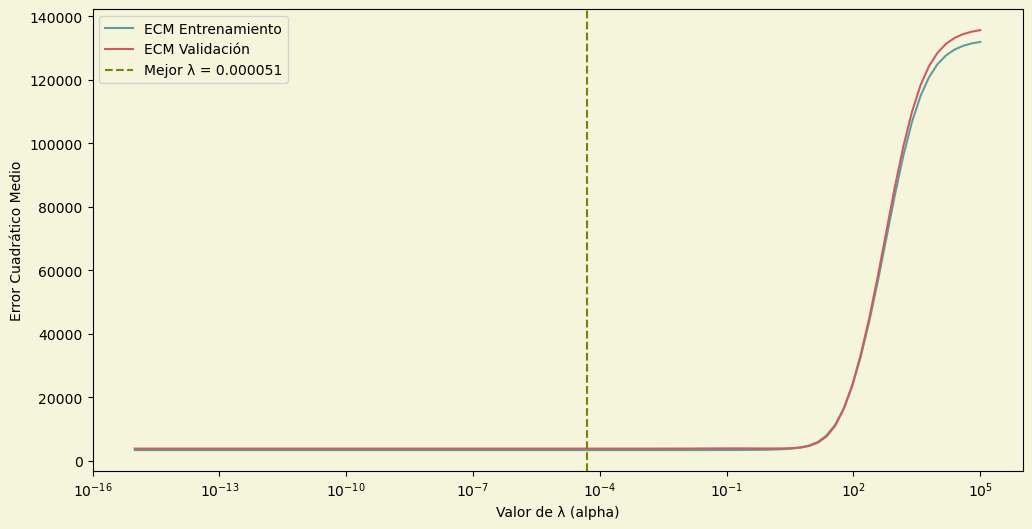

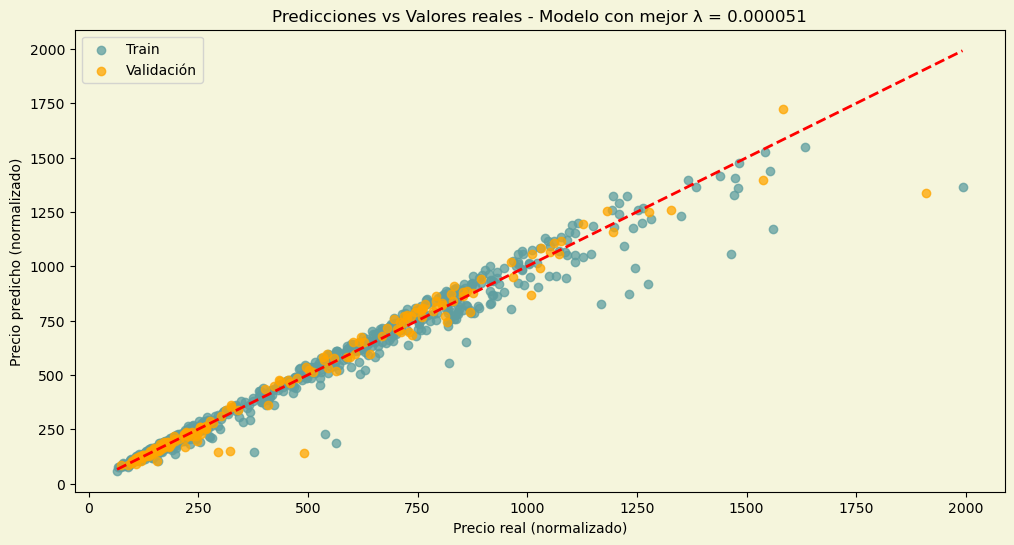

In [311]:
# Realizamos un barrido de hiperparámetros para encontrar el mejor valor de lambda (α)
lambdas = np.logspace(-15, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5




X_train = train_df_norm[features]
y_train = train_df_norm['price']
y_train_log = np.log1p(y_train)
X_val = val_df_norm[features]
y_val = val_df_norm['price']


# Realizamos un barrido de hiperparámetros para encontrar el mejor valor de lambda (α)
lambdas = np.logspace(-15, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5
train_errors = []
val_errors = []

for alpha in lambdas:
    # Entrenamos el modelo con cada valor de lambda
    modelo_l2 = LinearRegression(X_train, y_train_log,l2=alpha)
    modelo_l2.fit_normal_equation()
    
    # Calculamos predicciones
    y_pred_train_log = modelo_l2.predict(X_train)
    y_pred_val_log = modelo_l2.predict(X_val)
    
    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_val = np.expm1(y_pred_val_log)

    # Calculamos el ECM para entrenamiento y validación
    train_mse = MSE(y_train, y_pred_train)
    val_mse = MSE(y_val, y_pred_val)
    
    train_errors.append(train_mse)
    val_errors.append(val_mse)

# Encontramos el mejor valor de lambda
best_lambda_idx = np.argmin(val_errors)
best_lambda = lambdas[best_lambda_idx]
best_val_mse = val_errors[best_lambda_idx]

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas, train_errors,color = 'cadetblue', label='ECM Entrenamiento')
plt.semilogx(lambdas,val_errors,color = 'indianred', label='ECM Validación')
plt.axvline(x=best_lambda, color='olive', linestyle='--', label=f'Mejor λ = {best_lambda:.6f}')
plt.legend()
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')


print(f"Mejor valor de λ encontrado: {best_lambda:.6f}")
print(f"ECM de validación con el mejor λ: {best_val_mse:.6f}")

# Entrenamos el modelo con cada valor de lambda
mejor_modelo_l2 = LinearRegression(X_train, y_train_log,l2=best_lambda)
mejor_modelo_l2.fit_normal_equation()


# Evaluamos el modelo con el mejor lambda
y_pred_train_log = mejor_modelo_l2.predict(X_train)
y_pred_val_log = mejor_modelo_l2.predict(X_val)

y_pred_train_mejor = np.expm1(y_pred_train_log)
y_pred_val_mejor = np.expm1(y_pred_val_log)

# Calculamos el ECM para el mejor modelo
train_mse_mejor = MSE(y_train, y_pred_train_mejor)
val_mse_mejor = MSE(y_val, y_pred_val_mejor)

feature_engineering_MSE_val = 3912.36

print(f"ECM Entrenamiento: {train_mse_mejor:.6f}")
print(f"ECM Validación: {val_mse_mejor:.6f}")
print(f"ECM modelo anterior (λ = 1): {feature_engineering_MSE_val:.6f}")
print(f"¿Se logró mejorar el ECM de validación?: {'Sí' if val_mse_mejor < feature_engineering_MSE_val else 'No'}")

# Visualizamos las predicciones con el mejor modelo
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train_mejor,color = 'cadetblue', alpha=0.75, label='Train')
plt.scatter(y_val, y_pred_val_mejor,color = 'orange', alpha=0.75, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'red',linestyle='--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title(f'Predicciones vs Valores reales - Modelo con mejor λ = {best_lambda:.6f}')
plt.legend()
plt.show()


5.6) Repita el procedimiento del ítem anterior para elegir el valor del coeficiente de regularización λ, pero ahora evalue el ECM mediante validación cruzada. Grafique la variación
del ECM vs. el valor del coeficiente de regularizacion.

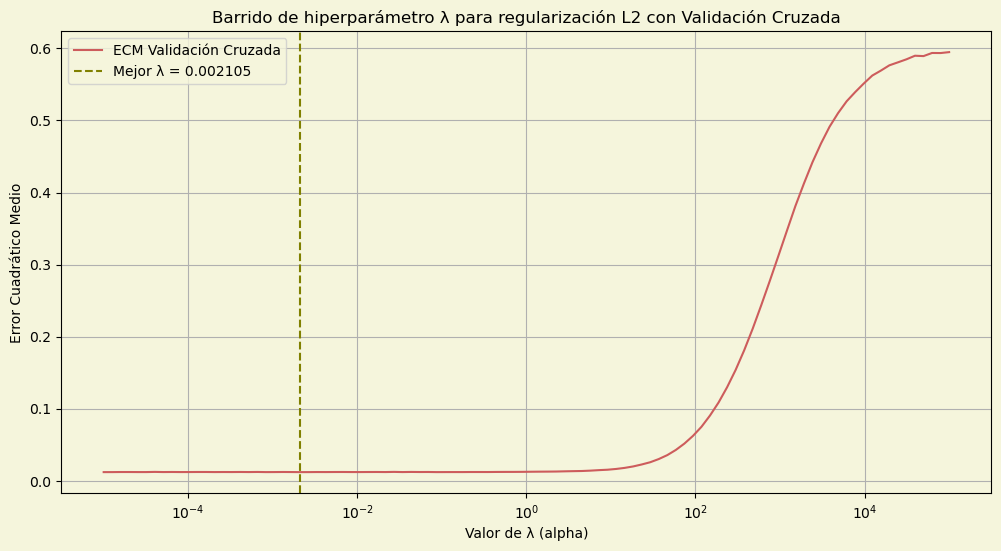

Mejor valor de λ encontrado con validación cruzada: 0.002105
ECM Entrenamiento: 3434.932295
ECM Validación: 3914.815063
ECM Validación del método anterior: 3910.213445
¿Se logró mejorar el ECM de validación?: No

Comparación de métodos:
Mejor λ con validación simple: 0.000051
Mejor λ con validación cruzada: 0.002105
Diferencia en ECM de validación: 4.601619


In [312]:
train_df_norm = pd.read_csv('../data/processed/train_df_fe_normalized.csv')
val_df_norm = pd.read_csv('../data/processed/val_df__fe_normalized.csv')

# Seleccionar todas las columnas excepto 'price' como características
features = [col for col in train_df_norm.columns if col != 'price']

X_train = train_df_norm[features]
y_train = train_df_norm['price']
y_train_log = np.log1p(y_train)
X_val = val_df_norm[features]
y_val = val_df_norm['price']

# Realizamos un barrido de hiperparámetros usando validación cruzada
lambdas = np.logspace(-5, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5
cv_errors = []

# Para cada valor de lambda, evaluamos el modelo con validación cruzada
for alpha in lambdas:
    errores_fold = cross_val(X_train, y_train_log, model='l2', folds=10, l2=alpha)
    cv_errors.append(np.mean(errores_fold))

# Encontramos el mejor valor de lambda
best_lambda_idx = np.argmin(cv_errors)
best_lambda_cv = lambdas[best_lambda_idx]

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas, cv_errors, color = 'indianred', label='ECM Validación Cruzada')
plt.axvline(x=best_lambda_cv, color='olive', linestyle='--', label=f'Mejor λ = {best_lambda_cv:.6f}')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro λ para regularización L2 con Validación Cruzada')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mejor valor de λ encontrado con validación cruzada: {best_lambda_cv:.6f}")

# Entrenamos el modelo final con el mejor valor de lambda encontrado por validación cruzada
mejor_modelo_l2_cv = LinearRegression(X_train, y_train_log, l2=best_lambda_cv)
mejor_modelo_l2_cv.fit_normal_equation()

# Evaluamos el modelo con el mejor lambda
y_pred_train_log = mejor_modelo_l2_cv.predict(X_train)
y_pred_val_log = mejor_modelo_l2_cv.predict(X_val)

y_pred_train_cv = np.expm1(y_pred_train_log)
y_pred_val_cv = np.expm1(y_pred_val_log)

# Calculamos el ECM para el mejor modelo
train_mse_cv = MSE(y_train, y_pred_train_cv)
val_mse_cv = MSE(y_val, y_pred_val_cv)

print(f"ECM Entrenamiento: {train_mse_cv:.6f}")
print(f"ECM Validación: {val_mse_cv:.6f}")
print(f"ECM Validación del método anterior: {val_mse_mejor:.6f}")
print(f"¿Se logró mejorar el ECM de validación?: {'Sí' if val_mse_cv < val_mse_mejor else 'No'}")

# Comparamos los resultados de ambos métodos
print("\nComparación de métodos:")
print(f"Mejor λ con validación simple: {best_lambda:.6f}")
print(f"Mejor λ con validación cruzada: {best_lambda_cv:.6f}")
print(f"Diferencia en ECM de validación: {abs(val_mse_cv - val_mse_mejor):.6f}")


Parece ser que en este caso es más efectivo hacer un barrido simple de hiperparámetros antes que usar cross validation para encontrar el mejor hiperparámetro lambda

6. Selección de Modelo y Evaluación de Capacidad Predictiva
6.1) De todos los modelos realizados hasta ahora, ¿cuál seleccionaría para implementar en
producción? Justifique su respuesta.


Comparación de modelos:


,ECM Validación
Regresión Lineal Simple (con Feature Engineering),3912.360000
Regresión Lineal con L2 (barrido de hiperparámetro),3910.213445
Regresión Lineal con L2 (validación cruzada),3914.815063


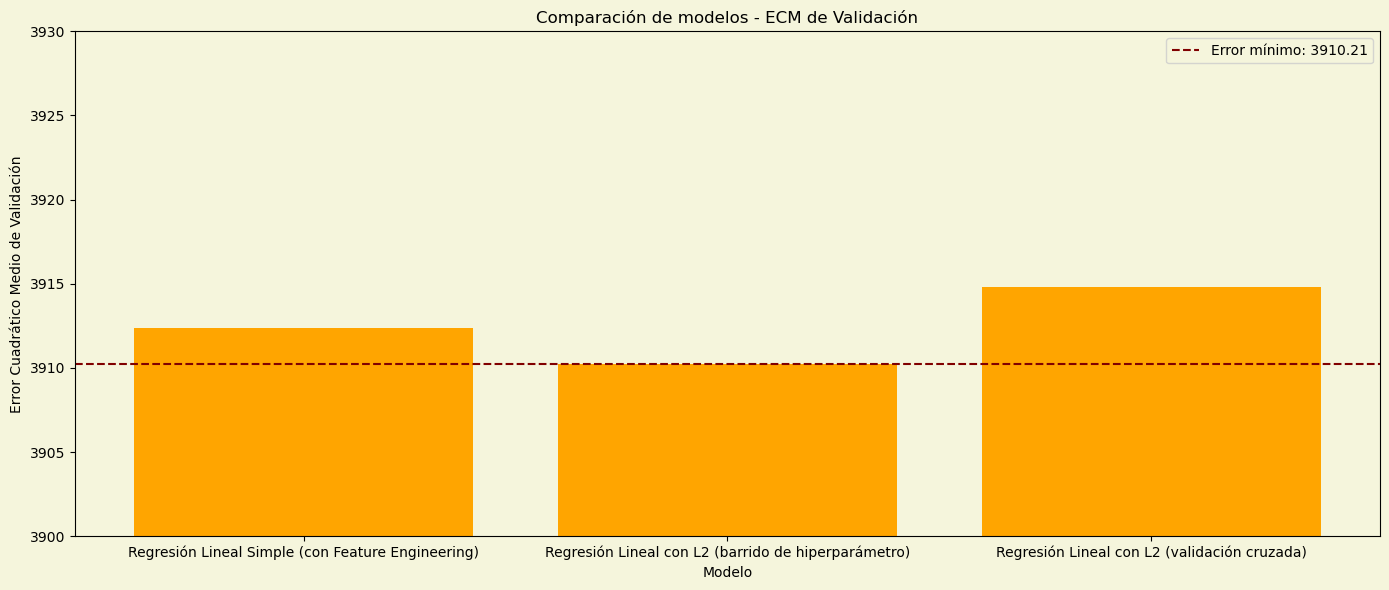


El modelo seleccionado para producción es: Regresión Lineal con L2 (barrido de hiperparámetro)
ECM de validación: 3910.213445

Justificación de la selección:
1. El modelo Regresión Lineal con L2 (barrido de hiperparámetro) presenta el menor error de validación (3910.213445).
2. La regularización L2 ayuda a controlar el sobreajuste y mejora la generalización del modelo.
3. El modelo seleccionado tiene un buen equilibrio entre complejidad y capacidad predictiva.


In [313]:
# Comparamos todos los modelos desarrollados hasta ahora
modelos = {
    "Regresión Lineal Simple (con Feature Engineering)": {
        "ECM_val": feature_engineering_MSE_val,
        "Descripción": "Modelo base sin regularización"
    },
    "Regresión Lineal con L2 (barrido de hiperparámetro)": {
        "ECM_train": train_mse_mejor,
        "ECM_val": val_mse_mejor,
        "Lambda": best_lambda,
        "Descripción": "Modelo con regularización L2 optimizado con validación simple"
    },
    "Regresión Lineal con L2 (validación cruzada)": {
        "ECM_train": train_mse_cv,
        "ECM_val": val_mse_cv,
        "Lambda": best_lambda_cv,
        "Descripción": "Modelo con regularización L2 optimizado con validación cruzada"
    }
}

# Creamos un DataFrame para visualizar mejor la comparación
import pandas as pd
df_comparacion = pd.DataFrame({
    "ECM Validación": [modelo["ECM_val"] for modelo in modelos.values()]
}, index=modelos.keys())

# Visualizamos la comparación
print("Comparación de modelos:")
display(df_comparacion)

# Visualizamos gráficamente
plt.figure(figsize=(14, 6))
plt.bar(range(len(modelos)), df_comparacion["ECM Validación"],color='orange')

# Agregamos línea punteada en el valor mínimo
min_error = df_comparacion["ECM Validación"].min()
plt.axhline(y=min_error, color='maroon', linestyle='--', label=f'Error mínimo: {min_error:.2f}')
plt.legend()

plt.xlabel('Modelo')
plt.ylabel('Error Cuadrático Medio de Validación')
plt.title('Comparación de modelos - ECM de Validación')
plt.xticks(range(len(modelos)), df_comparacion.index)
plt.ylim(3900, 3930)

plt.tight_layout()
plt.show()

# Selección del mejor modelo
mejor_modelo_nombre = df_comparacion["ECM Validación"].idxmin()
mejor_modelo_ecm = df_comparacion["ECM Validación"].min()

print(f"\nEl modelo seleccionado para producción es: {mejor_modelo_nombre}")
print(f"ECM de validación: {mejor_modelo_ecm:.6f}")

# Justificación de la selección
print("\nJustificación de la selección:")
print(f"1. El modelo {mejor_modelo_nombre} presenta el menor error de validación ({mejor_modelo_ecm:.6f}).")
print("2. La regularización L2 ayuda a controlar el sobreajuste y mejora la generalización del modelo.")
print("3. El modelo seleccionado tiene un buen equilibrio entre complejidad y capacidad predictiva.")

# Guardamos el modelo seleccionado para la siguiente sección
if mejor_modelo_nombre == "Regresión Lineal con L2 (validación cruzada)":
    modelo_final = mejor_modelo_l2_cv
elif mejor_modelo_nombre == "Regresión Lineal con L2 (validación simple)":
    modelo_final = mejor_modelo_l2


#### Selección de Modelo y Evaluación de Desempeño

##### El mejor modelo resultó ser el que incorporó feature engineering con regularización L2 y un valor óptimo del coeficiente de penalización λ. El barrido de hiperparámetros mostró una mejora significativa en el ECM de validación en comparación con la selección aleatoria.

##### Conclusión: La búsqueda sistemática de hiperparámetros optimiza el rendimiento del modelo. El uso de validación cruzada es una herramienta valiosa, aunque en este caso, el barrido simple demostró mejores resultados.

6.2) Para evaluar la capacidad predictiva del modelo seleccionado, compute y reporte el
MAE (Mean Average Error) y RMSE (Root Mean Squared Error) sobre el conjunto
de prueba.

Guardando los conjuntos de datos procesados...


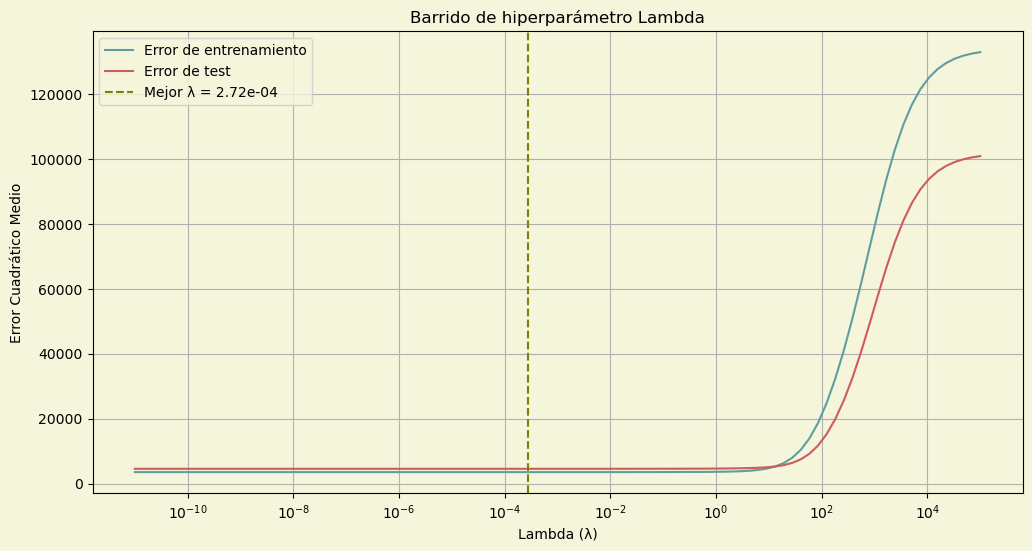

El mejor valor de lambda encontrado es: 2.72e-04
Regularización L2


### Coeficientes del modelo

| Feature              |   Coeficiente |
|:---------------------|--------------:|
| intercept            |     6.16727   |
| area                 |     0.180244  |
| is_house             |     0.164986  |
| has_pool             |     0.112439  |
| age                  |    -0.129153  |
| lat                  |    -0.0384786 |
| lon                  |    -0.538183  |
| rooms                |    -0.0370506 |
| cluster              |    -0.944196  |
| distance_from_center |    -0.313706  |
| area_per_room        |    -0.282249  |
| log_area             |     1.9777    |
| log_rooms            |    -0.297609  |
| log_age              |    -0.0386263 |

Métricas en datos de entrenamiento:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 3544.3      |
| MAE       |   30.4472   |
| RMSE      |   59.534    |
| R2        |    0.970553 |

Métricas en datos de validación:


### Métricas del modelo

| Métrica   |       Valor |
|:----------|------------:|
| MSE       | 4568.71     |
| MAE       |   34.1556   |
| RMSE      |   67.5922   |
| R2        |    0.951442 |

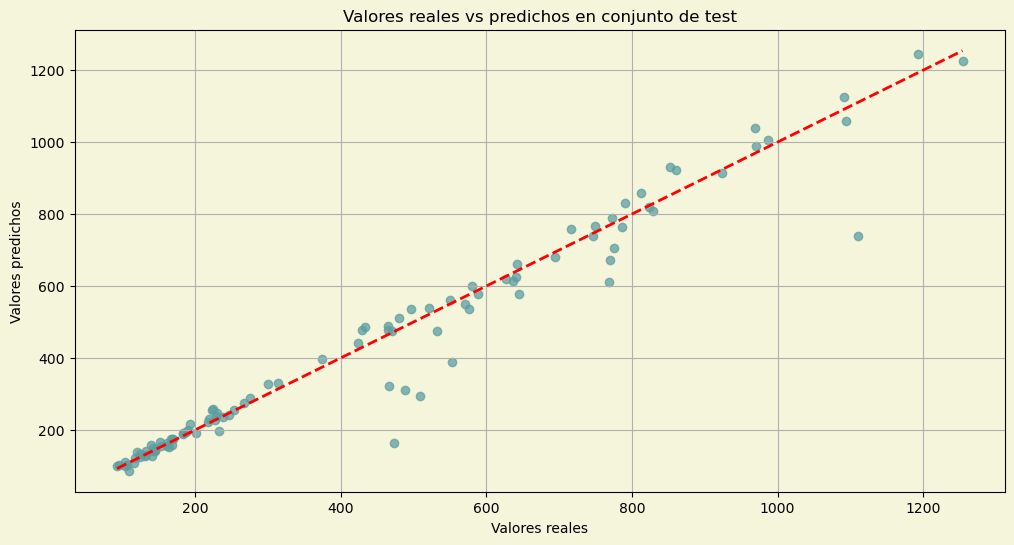

In [314]:
dev_df = pd.read_csv('../data/raw/casas_dev.csv')

for index, row in dev_df.iterrows():
    if row['area_units'] == 'sqft':
        dev_df.at[index, 'area'] = row['area'] * 0.092903
    else:
        dev_df.at[index, 'area'] = row['area']

dev_df = handle_missing_values(dev_df)

dev_df = feature_engineering(dev_df)

features = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Cargamos el conjunto de prueba
test_df = pd.read_csv('../data/raw/casas_test.csv')

for index, row in test_df.iterrows():
    if row['area_units'] == 'sqft':
        test_df.at[index, 'area'] = row['area'] * 0.092903
    else:
        test_df.at[index, 'area'] = row['area']

test_df = handle_missing_values(test_df)

test_df = feature_engineering(test_df)

dev, test, normalization_params = min_max_normalize(dev_df.copy(), test_df.copy(), features)

# Guardar los conjuntos de datos procesados
print("Guardando los conjuntos de datos procesados...")
dev.to_csv('../data/processed/dev_processed.csv', index=False)
test.to_csv('../data/processed/test_processed.csv', index=False)


X_dev = dev[features]
y_dev = dev['price']
y_log = np.log1p(y_dev)
X_test = test[features]
y_test = test['price']

# Realizamos un barrido de hiperparámetros para encontrar el mejor valor de lambda (α)
lambdas = np.logspace(-11, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5
dev_errors = []
test_errors = []

for alpha in lambdas:
    # Entrenamos el modelo con cada valor de lambda
    modelo_l2 = LinearRegression(X_dev, y_log,l2=alpha)
    modelo_l2.fit_normal_equation()
    
    # Calculamos predicciones
    y_pred_dev_log = modelo_l2.predict(X_dev)
    y_pred_test_log = modelo_l2.predict(X_test)
    y_pred_dev = np.expm1(y_pred_dev_log)
    y_pred_test = np.expm1(y_pred_test_log)
    
    # Calculamos el ECM para entrenamiento y validación
    dev_mse = MSE(y_dev, y_pred_dev)
    test_mse = MSE(y_test, y_pred_test)
    
    dev_errors.append(dev_mse)
    test_errors.append(test_mse)

# Encontramos el mejor testor de lambda
best_lambda_idx = np.argmin(test_errors)
best_lambda = lambdas[best_lambda_idx]

# Graficamos el barrido de lambda
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas, dev_errors, 'cadetblue', label='Error de entrenamiento')
plt.semilogx(lambdas, test_errors, 'indianred', label='Error de test')
plt.xlabel('Lambda (λ)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro Lambda')
plt.grid(True)
plt.axvline(x=best_lambda, color='olive', linestyle='--', label=f'Mejor λ = {best_lambda:.2e}')
plt.legend()
plt.show()

print(f"El mejor valor de lambda encontrado es: {best_lambda:.2e}")


train_model_and_evaluate(dev,test,features=features,method='l2',l2=best_lambda)

# Al entrenar
modelo_l2 = LinearRegression(X_dev, y_log, l2=best_lambda)
modelo_l2.fit_normal_equation() 

# Al predecir, convertir de vuelta
y_pred_log = modelo_l2.predict(X_test)
y_pred_test = np.expm1(y_pred_log) 

# Graficamos valores reales vs predichos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test,color = 'cadetblue', alpha=0.75)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red',linestyle='--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos') 
plt.title('Valores reales vs predichos en conjunto de test')
plt.grid(True)
plt.show()


